In [1]:
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()

# Extract Remarks Features

In [2]:
def display_topics(model, feature_names, n_top_words):
    topic_top_words = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_str = " ".join(top_words)
        print(top_words_str)
        topic_top_words.append(top_words_str)
    return topic_top_words

In [3]:
# load data
with open('data/features/CON_feats_all_cleaned.pkl', 'rb') as file:
    con_data_all = pickle.load(file)
print('con_data_all shape:', con_data_all.shape)

# merge remarks with all other features
df_remarks = pd.read_csv('merge_sold/MERGE_CON_SOLD.csv', usecols=['MLSNUM','REMARKS'], dtype={'MLSNUM':str})
con_data_remarks = pd.merge(con_data_all, df_remarks, how='inner', on='MLSNUM')
print('Merged REMARKS with all other features, shape:', con_data_remarks.shape)

# fill missing remarks
con_data_remarks['REMARKS'].fillna('', inplace=True)
print('After filling missing remarks, there are {} NA remarks'.format(sum(con_data_remarks.REMARKS.isnull())))

con_data_all shape: (40936, 2086)
Merged REMARKS with all other features, shape: (40936, 2087)
After filling missing remarks, there are 0 NA remarks


In [4]:
# Process remarks
documents = list(con_data_remarks['REMARKS'])
print('Total {} remarks (documents)'.format(len(documents)))

# read the NLTK listed stop_words
stop_words = []
f = open('nltk_stop_words.txt')
for word in f.readlines():
    stop_words.append(word.strip())

print('Total {} stop_words'.format(len(stop_words)))

# transform documents to tfidf for NMF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# transform documents to raw term counts for LDA
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
print('transformed tfidf.shape = {}, tf.shape = {}'.format(tfidf.shape, tf.shape))

n_components = 10
# Run NMF
nmf = NMF(n_components=n_components, random_state=9001, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_trans = nmf.transform(tfidf)
# Run LDA
lda = LatentDirichletAllocation(n_components=n_components, learning_method='online', learning_offset=50., random_state=9001).fit(tf)
lda_trans = lda.transform(tf)

# Print top topics
n_top_words = 6
print('=== NMF top topics ===')
nmf_topics = display_topics(nmf, tfidf_feature_names, n_top_words)
print('\n=== LDA top topics ===')
lda_topics = display_topics(lda, tf_feature_names, n_top_words)

Total 40936 remarks (documents)
Total 127 stop_words
transformed tfidf.shape = (40936, 23031), tf.shape = (40936, 23031)
=== NMF top topics ===
Topic 0:
master closet suite walk custom bath
Topic 1:
unit great condo location close well
Topic 2:
boston building street high parking square
Topic 3:
new brand flooring painted updated appliances
Topic 4:
pool tennis room courts amenities club
Topic 5:
community baths today homes call appointment
Topic 6:
room level family home living finished
Topic 7:
water fee hot heat condo includes
Topic 8:
house 12 30 sunday 00 open
Topic 9:
floor first second bath full two

=== LDA top topics ===
Topic 0:
views building concierge center boston fitness
Topic 1:
boston views home square city restaurants
Topic 2:
room floor bath living master kitchen
Topic 3:
charles park longwood mall score brookline
Topic 4:
buyer property seller offers condo owner
Topic 5:
new custom appliances stainless high lighting
Topic 6:
floor condo community unit new units
Topic

In [5]:
nmf_trans.shape, lda_trans.shape

((40936, 10), (40936, 10))

In [6]:
# Build dataframe for remark topics
nmf_cols = ['nmf_{}'.format(i) for i in range(nmf_trans.shape[1])]
lda_cols = ['lda_{}'.format(i) for i in range(lda_trans.shape[1])]
df_nmf = pd.DataFrame(nmf_trans, index=con_data_remarks.index, columns=nmf_cols)
df_lda = pd.DataFrame(lda_trans, index=con_data_remarks.index, columns=lda_cols)

# Merge dataframes
df_merge_remarks = pd.concat((con_data_remarks, df_nmf, df_lda), axis=1)
df_merge_remarks.shape

(40936, 2107)

In [7]:
# Save all features with remarks
df_merge_remarks.to_pickle('data/features/CON_feats_remarks.pkl')

# EDA on remark features

In [9]:
# Load all features with remark 
with open('data/features/CON_feats_remarks.pkl', 'rb') as file:
    df_merge_remarks = pickle.load(file)

# Add column for log-scaled response
df_merge_remarks['LOG_SOLDPRICE'] = np.log(df_merge_remarks['SOLDPRICE'])
df_merge_remarks['LOG_DOM'] = np.log(np.log(df_merge_remarks['DOM']))

In [11]:
def price_vs_remarks_feature(df, feature, subtitle, ax):
    sns.regplot(x=df[feature], y=df.LOG_SOLDPRICE, scatter_kws={'alpha':0.2}, color=color[0], ax=ax)
    # set titles
    ax.set_title("Log Sold Price vs. " + feature + "\n" + subtitle, fontsize=16)
    # label axes
    ax.set_ylabel("Log Sold Price", fontsize=14)
    ax.set_xlabel(feature, fontsize=14)

def dom_vs_remarks_feature(df, feature, subtitle, ax):
    sns.regplot(x=df[feature], y=df.LOG_DOM, scatter_kws={'alpha':0.2}, color=color[0], ax=ax)
    # set titles
    ax.set_title("Log DOM vs. " + feature + "\n" + subtitle, fontsize=16)
    # label axes
    ax.set_ylabel("Log DOM", fontsize=14)
    ax.set_xlabel(feature, fontsize=14)

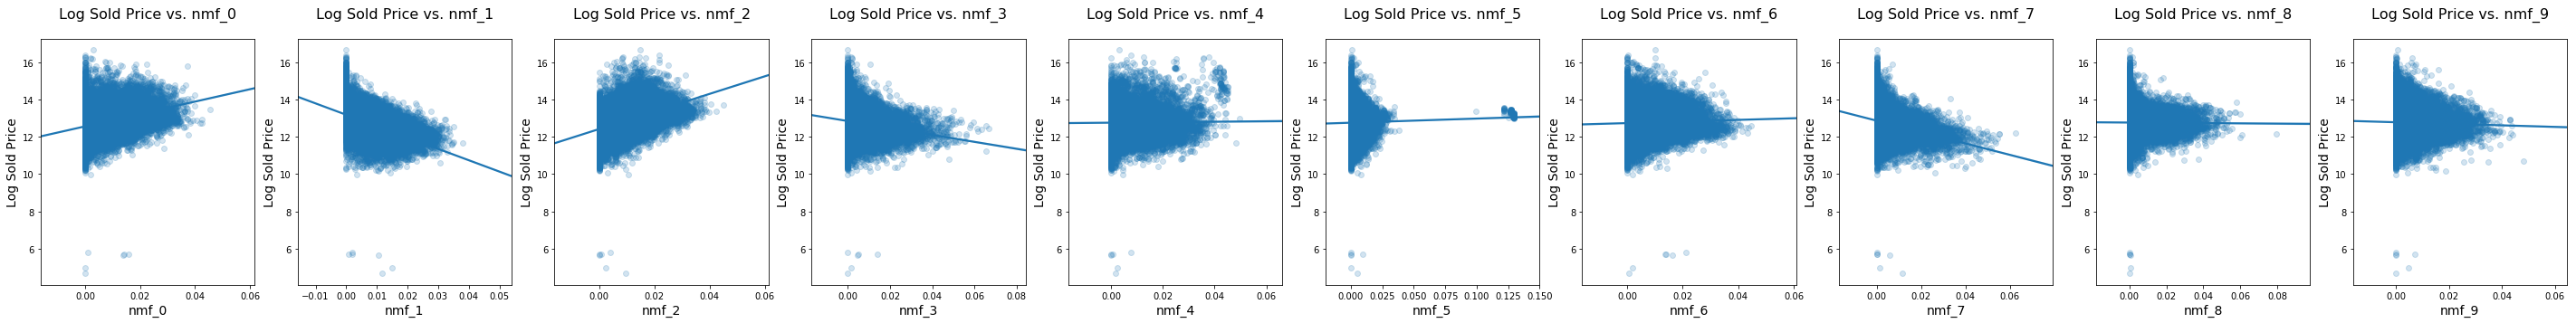

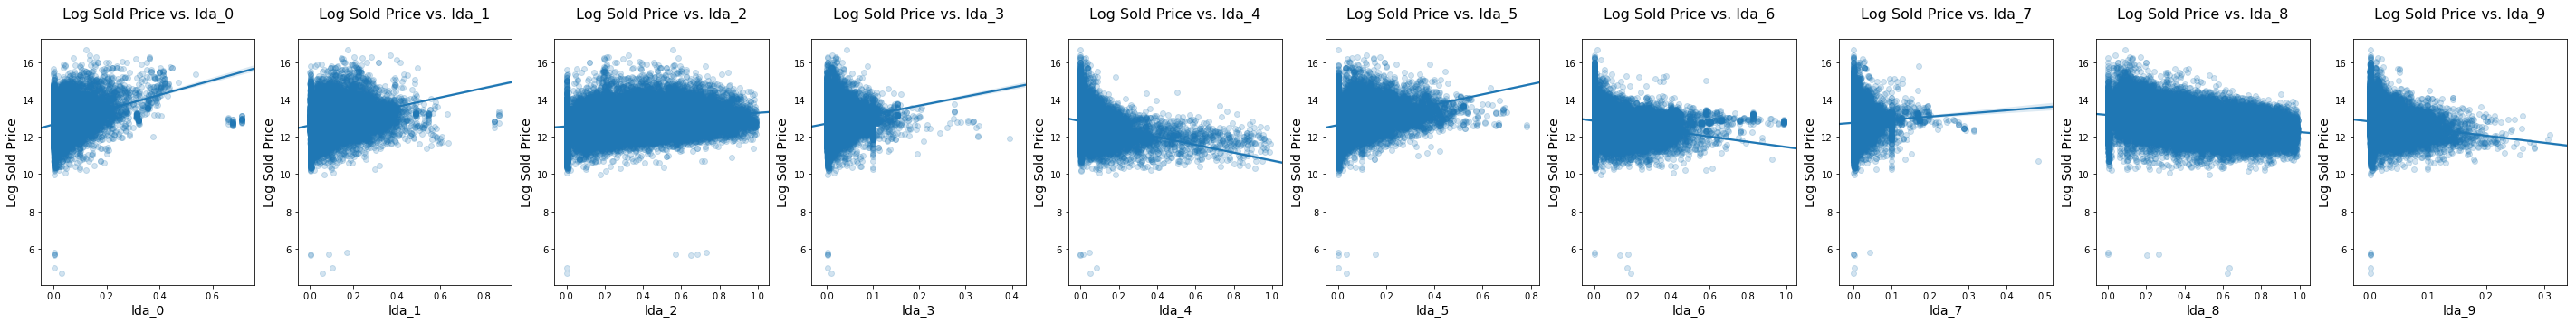

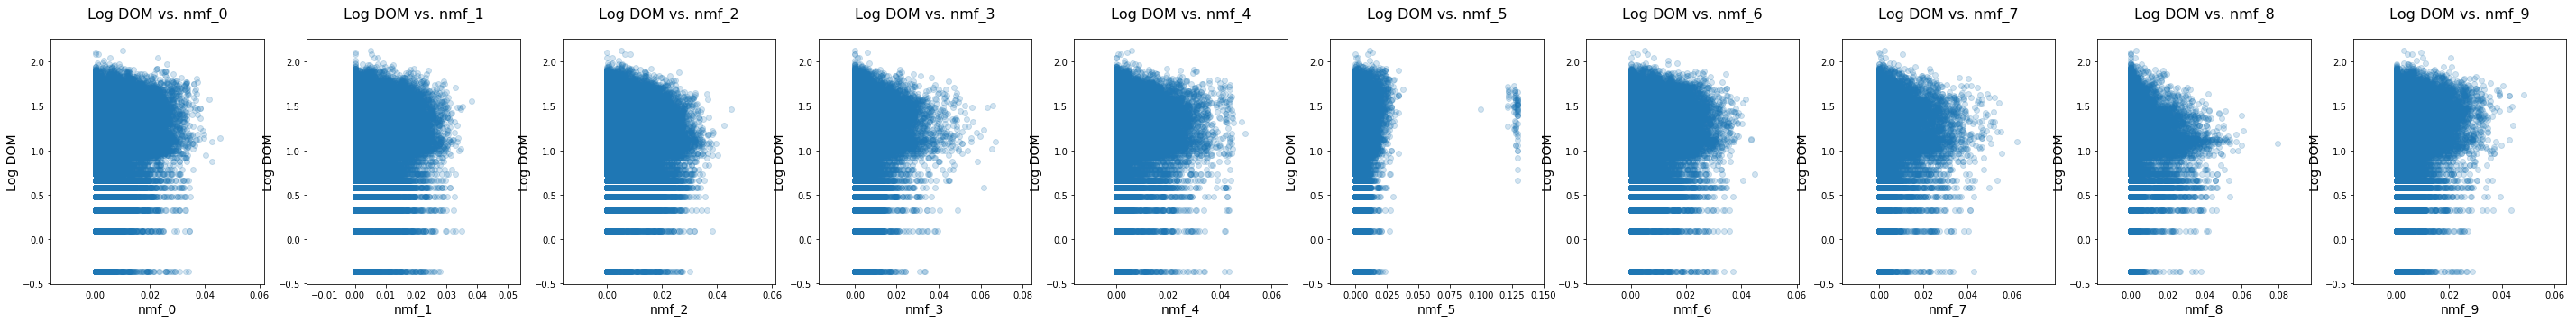

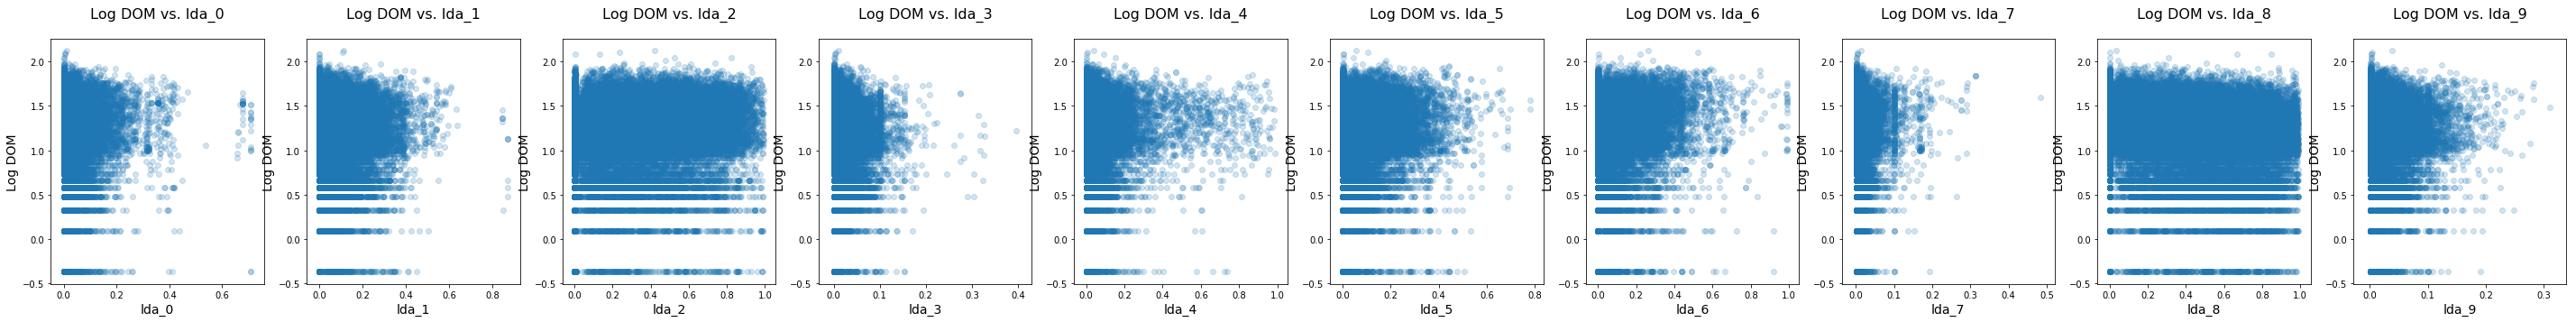

In [12]:
# log(PRICE) vs. nmf features
fig, ax = plt.subplots(1, nmf_trans.shape[1], figsize=(50, 5))
for i, feat in enumerate(nmf_cols):
    price_vs_remarks_feature(df_merge_remarks, feat, '', ax=ax[i])

# log(PRICE) vs. lda features
fig, ax = plt.subplots(1, lda_trans.shape[1], figsize=(50, 5))
for i, feat in enumerate(lda_cols):
    price_vs_remarks_feature(df_merge_remarks, feat, '', ax=ax[i])

# log(DOM) vs. nmf features
fig, ax = plt.subplots(1, nmf_trans.shape[1], figsize=(50, 5))
for i, feat in enumerate(nmf_cols):
    dom_vs_remarks_feature(df_merge_remarks, feat, '', ax=ax[i])

# log(DOM) vs. lda features
fig, ax = plt.subplots(1, lda_trans.shape[1], figsize=(50, 5))
for i, feat in enumerate(lda_cols):
    dom_vs_remarks_feature(df_merge_remarks, feat, '', ax=ax[i])